In [ ]:
import os

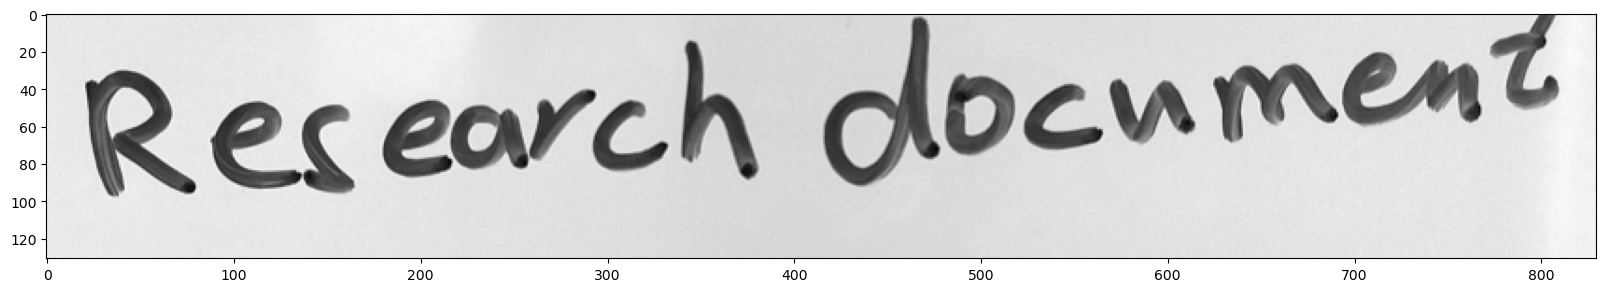

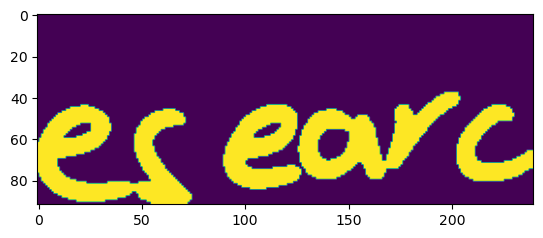

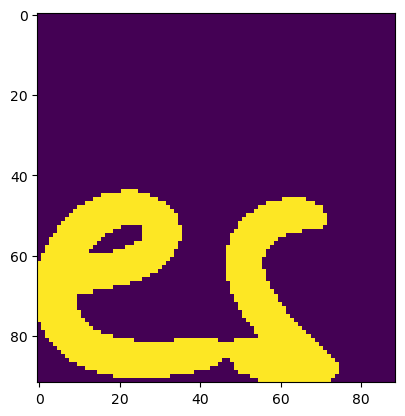

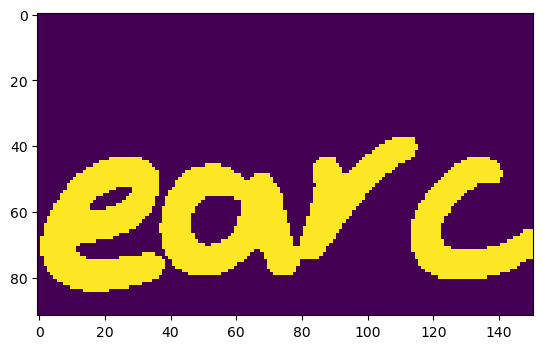

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import warnings

warnings.filterwarnings("ignore")

img = cv2.imread("images/img_21.png", 0)


def show(img, figsize=(20, 20)):
    fig = plt.figure(figsize=figsize)
    plt.imshow(img, cmap="gray")
    plt.show()


show(img)


def borders(here_img, thresh, bthresh=0.092):
    shape = here_img.shape
    #check = int(115 * size[0] / 600)
    #check = int(55 * size[0] / 600)
    check = int(bthresh * shape[0])
    image = here_img[:]
    top, bottom = 0, shape[0] - 1
    #plt.imshow(image)
    #plt.show()

    #find the background color for empty column
    bg = np.repeat(thresh, shape[1])
    count = 0
    for row in range(1, shape[0]):
        if (np.equal(bg, image[row]).any()) == True:
            #print(count)
            count += 1
        else:
            count = 0
        if count >= check:
            top = row - check
            break

    bg = np.repeat(thresh, shape[1])
    count = 0
    rows = np.arange(1, shape[0])
    #print(rows)
    for row in rows[::-1]:
        if (np.equal(bg, image[row]).any()) == True:
            count += 1
        else:
            count = 0
        if count >= check:
            bottom = row + count
            break

    d1 = (top - 2) >= 0
    d2 = (bottom + 2) < shape[0]
    d = d1 and d2
    if (d):
        b = 2
    else:
        b = 0

    return (top, bottom, b)


def preprocess(bgr_img):  #gray image
    blur = cv2.GaussianBlur(bgr_img, (5, 5), 0)
    ret, th_img = cv2.threshold(blur, 0, 255,
                                cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)  #converts black to white and inverse

    rows, cols = th_img.shape
    bg_test = np.array([th_img[i][i] for i in range(5)])
    if bg_test.all() == 0:
        text_color = 255
    else:
        text_color = 0

    tb = borders(th_img, text_color)
    lr = borders(th_img.T, text_color)
    dummy = int(np.average((tb[2], lr[2]))) + 2
    template = th_img[tb[0] + dummy:tb[1] - dummy, lr[0] + dummy:lr[1] - dummy]

    plt.imshow(template)
    plt.show()
    return (template, tb, lr)


prepimg, tb, lr = preprocess(img)


def segmentation(bordered, thresh=255, min_seg=1, scheck=0.1):
    try:
        shape = bordered.shape
        check = int(scheck * shape[0])
        image = bordered[:]
        image = image[check:].T
        shape = image.shape
        #plt.imshow(image)
        #plt.show()

        #find the background color for empty column
        bg = np.repeat(255 - thresh, shape[1])
        bg_keys = []
        for row in range(1, shape[0]):
            if (np.equal(bg, image[row]).all()):
                bg_keys.append(row)

        lenkeys = len(bg_keys) - 1
        new_keys = [bg_keys[1], bg_keys[-1]]
        #print(lenkeys)
        for i in range(1, lenkeys):
            if (bg_keys[i + 1] - bg_keys[i]) > check:
                new_keys.append(bg_keys[i])
                #print(i)

        new_keys = sorted(new_keys)
        #print(new_keys)
        segmented_templates = []
        first = 0
        bounding_boxes = []
        for key in new_keys[1:]:
            segment = bordered.T[first:key]
            if segment.shape[0] >= min_seg and segment.shape[1] >= min_seg:
                segmented_templates.append(segment.T)
                bounding_boxes.append((first, key))
            first = key

        last_segment = bordered.T[new_keys[-1]:]
        if last_segment.shape[0] >= min_seg and last_segment.shape[1] >= min_seg:
            segmented_templates.append(last_segment.T)
            bounding_boxes.append((new_keys[-1], new_keys[-1] + last_segment.shape[0]))

        return (segmented_templates, bounding_boxes)
    except:
        return [bordered, (0, bordered.shape[1])]


segments = segmentation(prepimg)
for simg in segments[0]:
    plt.imshow(simg)
    plt.show()


In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess(bgr_img):
    blur = cv2.GaussianBlur(bgr_img, (5, 5), 0)
    ret, th_img = cv2.threshold(blur, 0, 255,
                                cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)  #converts black to white and inverse

    # Join small gaps between letters and dots
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    th_img = cv2.morphologyEx(th_img, cv2.MORPH_CLOSE, kernel)

    rows, cols = th_img.shape
    bg_test = np.array([th_img[i][i] for i in range(5)])
    if bg_test.all() == 0:
        text_color = 255
    else:
        text_color = 0

    tb = borders(th_img, text_color)
    lr = borders(th_img.T, text_color)
    dummy = int(np.average((tb[2], lr[2]))) + 2
    template = th_img[tb[0] + dummy:tb[1] - dummy, lr[0] + dummy:lr[1] - dummy]

    plt.imshow(template)
    plt.show()
    return (template, tb, lr)

def segment_letters(img):
    # Find contours of connected components
    contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter out small contours
    min_area = 50
    contours = [c for c in contours if cv2.contourArea(c) > min_area]

    # Sort contours left-to-right
    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0])

    # Extract each letter as a separate image
    letters = []
    for contour in contours:
        x,y,w,h = cv2.boundingRect(contour)
        letter = img[y:y+h, x:x+w]
        letters.append(letter)

    return letters

# Load image and preprocess
img = cv2.imread("images/img_18.png")
processed = preprocess(img)

# Segment letters and display
letters = segment_letters(processed)
fig, axes = plt.subplots(1, len(letters), figsize=(20,20))
for i, letter in enumerate(letters):
    axes[i].imshow(letter, cmap="gray")
    axes[i].axis('off')
plt.show()

error: OpenCV(4.7.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/thresh.cpp:1555: error: (-2:Unspecified error) in function 'double cv::threshold(cv::InputArray, cv::OutputArray, double, double, int)'
> THRESH_OTSU mode:
>     'src_type == CV_8UC1 || src_type == CV_16UC1'
> where
>     'src_type' is 16 (CV_8UC3)
